In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle as pkl
from tqdm.notebook import tqdm
%matplotlib inline

sys.path.append(os.path.abspath('..'))
from cell_detection.cell_detection import detect_cells


This notebook contains statistics about segmentation areas and number of cells for biofilms treated with different antimicrobial compounds

In [2]:
dirpath = '../data/antibiotics_segmentation_results/'

In [3]:
seg_preds = {}
for filename in os.listdir(dirpath):
    if filename.endswith('.pkl'):
        with open(dirpath + filename, 'rb') as f:
            res = pkl.load(f)
            seg_preds[filename] = res

In [7]:
seg_preds[f'BX5(14)_results.pkl'][0]

array([[[[4.7654343e-01, 3.9935452e-01, 5.0081801e-01, ...,
          7.4291652e-01, 6.9090581e-01, 5.1011801e-01],
         [4.0763736e-01, 3.6454722e-01, 4.8667100e-01, ...,
          8.2347029e-01, 7.2324288e-01, 5.9510744e-01],
         [4.4712654e-01, 4.7428539e-01, 6.4456695e-01, ...,
          9.0960449e-01, 8.5879451e-01, 7.3169702e-01],
         ...,
         [5.0177294e-01, 5.4789472e-01, 7.6723146e-01, ...,
          4.9799073e-01, 5.2735448e-01, 4.7882167e-01],
         [5.0561833e-01, 4.9916145e-01, 7.2165006e-01, ...,
          5.4266107e-01, 4.9954247e-01, 5.0422066e-01],
         [4.5413023e-01, 4.5474216e-01, 6.2614423e-01, ...,
          5.4691851e-01, 4.8823979e-01, 5.1014507e-01]],

        [[3.7394795e-01, 3.8797781e-01, 4.9079803e-01, ...,
          3.4833899e-01, 2.9355058e-01, 3.0718726e-01],
         [3.1557885e-01, 3.7923554e-01, 4.7103217e-01, ...,
          3.3989307e-01, 2.1869649e-01, 2.1556778e-01],
         [3.9878127e-01, 4.2476019e-01, 4.9689898e-01, .

In [7]:
colors_dict = {
    'bacteria' : (251, 186, 14),
    'matrix': (64, 105, 42),
    'channel': (55, 94, 152),
    'cells-free zone': (236, 102, 70)}

def get_mask_tensor(pred, proba_thresh=None):
    probas_tensor = pred[0].max(axis=0)
    mask_tensor = pred[0].argmax(axis=0)
    if proba_thresh:
        mask_tensor[probas_tensor < proba_thresh] = 3
        
    masked_image = np.zeros(shape=(mask_tensor.shape[0], mask_tensor.shape[1], 3))
    
    for i, layer in enumerate(list(colors_dict.keys())):
            masked_image[:,:][mask_tensor == i] = colors_dict[layer]
            
    return masked_image.astype('uint8'), mask_tensor

In [8]:
def imgByindex(antibiotics_name, i):
    path = '../data/'
    add_path = f'antibiotics_images/{antibiotics_name}/{antibiotics_name}00{str(i).zfill(2)}.tif'
    path = os.path.join(path, add_path)
    image = cv2.imread(path)
    return image[:-64*2]

In [9]:
def maskByindex(antibiotics_name, i, seg_class=0, seg_preds=seg_preds):
    mask_tensor = seg_preds[f'{antibiotics_name}_results.pkl'][i][0].argmax(axis=0)
    if seg_class == 'cell+matrix':
        mask_tensor[(mask_tensor != 0) & (mask_tensor != 1)] = -1
        mask_tensor[mask_tensor == 0] = 1
        mask_tensor[mask_tensor == 1] = 1
    else:
        mask_tensor[mask_tensor != seg_class] = -1
        mask_tensor[mask_tensor == seg_class] = 1
        
    mask_tensor[mask_tensor == -1] = 0
    return mask_tensor

## Segmentation classes calculation in antibiotics 

In [16]:
def get_seg_ratios_in_pic(mask_tensor):
    ratios = {
        0: 0,
        1: 0,
        2: 0,
        3: 0
    }
    labels, values = np.unique(mask_tensor, return_counts=True)
    values_proc = values/sum(values)*100
    for label, value_proc in zip(labels, values_proc):
        ratios[label] = value_proc
        
    return ratios

In [17]:
for antibiotics_name in ['BX5(14)', 'GEN30', 'HL30', 'TIG30']:
    df = pd.DataFrame(columns=['Cells', 'Matrix', 'Channels', 'Cells-free zone', 'Number of cells'])
    preds = seg_preds[f"{antibiotics_name}_results.pkl"]
    for i in tqdm(range(len(preds))):
        pred = preds[i]
        _, mask_tensor = get_mask_tensor(pred)
        
        image = imgByindex(antibiotics_name, i)
        cell_mask = maskByindex(antibiotics_name, i, seg_class=0, seg_preds=seg_preds)
        coords, labels = detect_cells(image, x_1=0, x_2=1280, y_1=0, y_2=832, cell_mask=cell_mask, figsize=None, path=None)
        cell_count = len(coords)
            
        ratios = get_seg_ratios_in_pic(mask_tensor)
        df = df.append({'Cells': f'{round(ratios[0], 1)}%',
                        'Matrix': f'{round(ratios[1], 1)}%',
                        'Channels': f'{round(ratios[2], 1)}%',
                        'Cells-free zone': f'{round(ratios[3], 1)}%',
                        'Number of cells': str(cell_count)}, ignore_index = True)
    df.to_csv(dirpath + f'area_calculations_{antibiotics_name}.csv')


100%|██████████| 148/148 [00:00<00:00, 271547.24it/s]

100%|██████████| 136/136 [00:00<00:00, 349.34it/s]

100%|██████████| 135/135 [00:00<00:00, 129129.09it/s]

100%|██████████| 124/124 [00:00<00:00, 376.81it/s]

100%|██████████| 118/118 [00:00<00:00, 224050.64it/s]

100%|██████████| 111/111 [00:00<00:00, 368.67it/s][A

100%|██████████| 81/81 [00:00<00:00, 195927.70it/s]

100%|██████████| 78/78 [00:00<00:00, 357.61it/s]

100%|██████████| 136/136 [00:00<00:00, 333972.68it/s]

100%|██████████| 128/128 [00:00<00:00, 381.68it/s]

100%|██████████| 117/117 [00:00<00:00, 211888.41it/s]

100%|██████████| 106/106 [00:00<00:00, 371.99it/s][A

100%|██████████| 72/72 [00:00<00:00, 205295.64it/s]

100%|██████████| 70/70 [00:00<00:00, 362.58it/s]

100%|██████████| 142/142 [00:00<00:00, 129928.27it/s]

100%|██████████| 134/134 [00:00<00:00, 365.89it/s]

100%|██████████| 137/137 [00:00<00:00, 392768.04it/s]

100%|██████████| 132/132 [00:00<00:00, 373.77it/s]

100%|██████████| 120/120 [00:00<00:00, 1

100%|██████████| 126/126 [00:00<00:00, 381.10it/s]

100%|██████████| 48/48 [00:00<00:00, 210592.67it/s]

100%|██████████| 43/43 [00:00<00:00, 330.72it/s]

100%|██████████| 137/137 [00:00<00:00, 115316.00it/s]

100%|██████████| 128/128 [00:00<00:00, 347.28it/s]

100%|██████████| 128/128 [00:00<00:00, 329570.85it/s]

100%|██████████| 116/116 [00:00<00:00, 345.12it/s]

100%|██████████| 128/128 [00:00<00:00, 342610.66it/s]

100%|██████████| 120/120 [00:00<00:00, 354.65it/s]

100%|██████████| 5/5 [00:00<00:00, 74104.31it/s]

100%|██████████| 5/5 [00:00<00:00, 293.30it/s]

100%|██████████| 83/83 [00:00<00:00, 308623.43it/s]

100%|██████████| 81/81 [00:00<00:00, 345.01it/s]

100%|██████████| 113/113 [00:00<00:00, 178112.12it/s]

100%|██████████| 105/105 [00:00<00:00, 348.65it/s][A

100%|██████████| 133/133 [00:00<00:00, 192226.89it/s]

100%|██████████| 125/125 [00:00<00:00, 346.27it/s]

100%|██████████| 61/61 [00:00<00:00, 188403.94it/s]

100%|██████████| 55/55 [00:00<00:00, 366.98it/s]

100%


100%|██████████| 31/31 [00:00<00:00, 149796.57it/s]

100%|██████████| 31/31 [00:00<00:00, 362.79it/s]

100%|██████████| 110/110 [00:00<00:00, 223209.21it/s]

100%|██████████| 106/106 [00:00<00:00, 366.48it/s][A

100%|██████████| 64/64 [00:00<00:00, 177889.63it/s]

100%|██████████| 62/62 [00:00<00:00, 369.03it/s]

100%|██████████| 48/48 [00:00<00:00, 295633.76it/s]

100%|██████████| 41/41 [00:00<00:00, 346.01it/s]

100%|██████████| 94/94 [00:00<00:00, 401082.99it/s]

100%|██████████| 84/84 [00:00<00:00, 361.01it/s]

100%|██████████| 63/63 [00:00<00:00, 358536.16it/s]

100%|██████████| 57/57 [00:00<00:00, 368.19it/s]

100%|██████████| 132/132 [00:00<00:00, 221017.22it/s]

100%|██████████| 124/124 [00:00<00:00, 372.36it/s]

100%|██████████| 117/117 [00:00<00:00, 400272.08it/s]

100%|██████████| 110/110 [00:00<00:00, 374.84it/s][A

100%|██████████| 102/102 [00:00<00:00, 216070.21it/s]

100%|██████████| 92/92 [00:00<00:00, 368.96it/s]

100%|██████████| 125/125 [00:00<00:00, 388937.69it/s]


100%|██████████| 76/76 [00:00<00:00, 371.62it/s]

100%|██████████| 129/129 [00:00<00:00, 119387.74it/s]

100%|██████████| 119/119 [00:00<00:00, 311.80it/s][A

100%|██████████| 125/125 [00:00<00:00, 366378.76it/s]

100%|██████████| 118/118 [00:00<00:00, 370.39it/s]

100%|██████████| 118/118 [00:00<00:00, 114064.96it/s]

100%|██████████| 111/111 [00:00<00:00, 381.50it/s][A

100%|██████████| 109/109 [00:00<00:00, 221394.25it/s]

100%|██████████| 103/103 [00:00<00:00, 370.24it/s][A

100%|██████████| 110/110 [00:00<00:00, 214492.53it/s]

100%|██████████| 101/101 [00:00<00:00, 374.92it/s][A

100%|██████████| 107/107 [00:00<00:00, 210897.80it/s]

100%|██████████| 100/100 [00:00<00:00, 383.24it/s][A

100%|██████████| 65/65 [00:00<00:00, 193217.41it/s]

100%|██████████| 59/59 [00:00<00:00, 363.74it/s]

100%|██████████| 89/89 [00:00<00:00, 192419.10it/s]

100%|██████████| 87/87 [00:00<00:00, 359.53it/s]

100%|██████████| 79/79 [00:00<00:00, 290913.10it/s]

100%|██████████| 75/75 [00:00<00:00, 37


100%|██████████| 121/121 [00:00<00:00, 130801.75it/s]

100%|██████████| 112/112 [00:00<00:00, 368.78it/s]

100%|██████████| 89/89 [00:00<00:00, 304729.03it/s]

100%|██████████| 80/80 [00:00<00:00, 363.59it/s]

100%|██████████| 68/68 [00:00<00:00, 183652.72it/s]

100%|██████████| 65/65 [00:00<00:00, 375.27it/s]

100%|██████████| 131/131 [00:00<00:00, 224083.94it/s]

100%|██████████| 127/127 [00:00<00:00, 377.85it/s]

100%|██████████| 148/148 [00:00<00:00, 234424.85it/s]

100%|██████████| 139/139 [00:00<00:00, 356.21it/s]

100%|██████████| 210/210 [00:00<00:00, 420833.18it/s]

100%|██████████| 205/205 [00:00<00:00, 383.27it/s]

100%|██████████| 183/183 [00:00<00:00, 363426.91it/s]

100%|██████████| 174/174 [00:00<00:00, 372.80it/s]

100%|██████████| 124/124 [00:00<00:00, 262673.58it/s]

100%|██████████| 121/121 [00:00<00:00, 355.96it/s]

100%|██████████| 151/151 [00:00<00:00, 358832.81it/s]

100%|██████████| 143/143 [00:00<00:00, 354.96it/s]

100%|██████████| 115/115 [00:00<00:00, 16667

100%|██████████| 114/114 [00:00<00:00, 342.90it/s]

100%|██████████| 133/133 [00:00<00:00, 351507.52it/s]

100%|██████████| 127/127 [00:00<00:00, 356.29it/s]

100%|██████████| 106/106 [00:00<00:00, 330800.76it/s]

100%|██████████| 98/98 [00:00<00:00, 356.08it/s]

100%|██████████| 146/146 [00:00<00:00, 423198.61it/s]

100%|██████████| 136/136 [00:00<00:00, 387.00it/s]

100%|██████████| 146/146 [00:00<00:00, 226467.60it/s]

100%|██████████| 133/133 [00:00<00:00, 375.81it/s]

100%|██████████| 130/130 [00:00<00:00, 223101.28it/s]

100%|██████████| 121/121 [00:00<00:00, 377.46it/s]

100%|██████████| 139/139 [00:00<00:00, 403745.33it/s]

100%|██████████| 132/132 [00:00<00:00, 378.68it/s]

100%|██████████| 123/123 [00:00<00:00, 218879.67it/s]

100%|██████████| 116/116 [00:00<00:00, 369.77it/s]

100%|██████████| 69/69 [00:00<00:00, 189031.34it/s]

100%|██████████| 68/68 [00:00<00:00, 368.10it/s]

100%|██████████| 80/80 [00:00<00:00, 361577.93it/s]

100%|██████████| 75/75 [00:00<00:00, 365.39it


100%|██████████| 167/167 [00:00<00:00, 257802.27it/s]

100%|██████████| 159/159 [00:00<00:00, 348.22it/s]

100%|██████████| 99/99 [00:00<00:00, 188315.69it/s]

100%|██████████| 91/91 [00:00<00:00, 347.59it/s]

100%|██████████| 38/38 [00:00<00:00, 175532.55it/s]

100%|██████████| 36/36 [00:00<00:00, 248.90it/s]

100%|██████████| 35/35 [00:00<00:00, 79095.17it/s]

100%|██████████| 32/32 [00:00<00:00, 301.33it/s]

100%|██████████| 58/58 [00:00<00:00, 284525.89it/s]

100%|██████████| 57/57 [00:00<00:00, 269.34it/s]

100%|██████████| 22/22 [00:00<00:00, 150284.51it/s]

100%|██████████| 22/22 [00:00<00:00, 321.90it/s]

100%|██████████| 100/100 [00:00<00:00, 321402.61it/s]

100%|██████████| 98/98 [00:00<00:00, 343.17it/s]

100%|██████████| 50/50 [00:00<00:00, 162822.36it/s]

100%|██████████| 49/49 [00:00<00:00, 342.85it/s]

100%|██████████| 16/16 [00:00<00:00, 107374.18it/s]

100%|██████████| 12/12 [00:00<00:00, 343.72it/s]

100%|██████████| 26/26 [00:00<00:00, 94254.02it/s]

100%|██████████

100%|██████████| 163/163 [00:00<00:00, 371.69it/s]

100%|██████████| 174/174 [00:00<00:00, 403209.33it/s]

100%|██████████| 164/164 [00:00<00:00, 383.02it/s]

100%|██████████| 159/159 [00:00<00:00, 419166.77it/s]

100%|██████████| 154/154 [00:00<00:00, 372.67it/s]

100%|██████████| 154/154 [00:00<00:00, 421620.64it/s]

100%|██████████| 146/146 [00:00<00:00, 384.79it/s]

100%|██████████| 172/172 [00:00<00:00, 430441.70it/s]

100%|██████████| 160/160 [00:00<00:00, 386.56it/s]

100%|██████████| 166/166 [00:00<00:00, 394925.96it/s]

100%|██████████| 153/153 [00:00<00:00, 388.78it/s]

100%|██████████| 170/170 [00:00<00:00, 219597.07it/s]

100%|██████████| 166/166 [00:00<00:00, 370.96it/s]

100%|██████████| 174/174 [00:00<00:00, 211049.42it/s]

100%|██████████| 164/164 [00:00<00:00, 382.95it/s]

100%|██████████| 176/176 [00:00<00:00, 442034.43it/s]

100%|██████████| 165/165 [00:00<00:00, 375.06it/s]

100%|██████████| 169/169 [00:00<00:00, 420425.49it/s]

100%|██████████| 163/163 [00:00<00:00

In [18]:
def get_seg_calcs(antibiotics_name):
    
    preds = seg_preds[f"{antibiotics_name}_results.pkl"]
    
    result = {
        0: [],
        1: [],
        2: [],
        3: []
    }
    
    for i in tqdm(range(len(preds))):
        pred = preds[i]
        _, mask_tensor = get_mask_tensor(pred)
        ratios = get_seg_ratios_in_pic(mask_tensor)
        
        for label in [0, 1, 2, 3]:
            result[label].append(ratios[label])
            
    return result

In [19]:
total_results = {
    'K': [0, 0, 0, 0],
    'BX5(14)': [0, 0, 0, 0],
    'GEN30': [0, 0, 0, 0],
    'HL30': [0, 0, 0, 0],
    'TIG30': [0, 0, 0, 0]
}

for name in ['K', 'BX5(14)', 'GEN30', 'HL30', 'TIG30']:
    result = get_seg_calcs(name)
    for i in range(4):
        total_results[name][i] = round(np.mean(result[i]), 1)

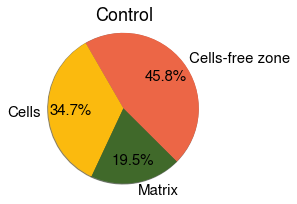

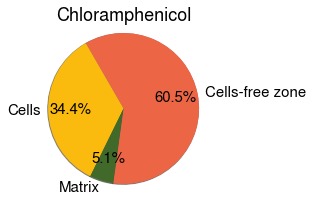

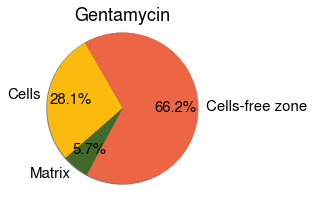

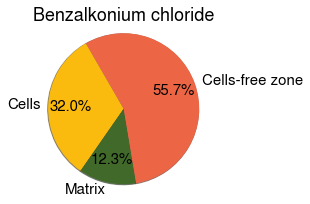

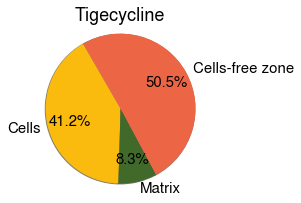

In [20]:
for key, name in zip(['K', 'HL30', 'GEN30', 'BX5(14)', 'TIG30'], ['Control', 'Chloramphenicol', 'Gentamycin', 'Benzalkonium chloride', 'Tigecycline']):
    vals = total_results[key]
    vals.pop(2)  # ignore channel zones as they are zeros
    plt.rcParams["font.family"] = "Nimbus Sans"
    plt.rcParams.update({'font.size': 15})
    plt.rcParams.update({'font.weight': 'regular'})

    labels = ["Cells", "Matrix", "Cells-free zone"]
    #explode = (0.1, 0.6, 0.6, 0.1)
    fig, ax = plt.subplots(figsize=(3, 3))
    plt.title(f'{name}')
    ax.pie(vals, labels=labels, explode=None, colors=['#FBBA0E', '#40692A', '#EC6646'],
           pctdistance=0.7, radius=3, shadow=True, autopct='%1.1f%%', startangle=120, textprops=dict(color="black"))

    ax.axis("equal")
    #plt.savefig(f'{key}_results_hists.png', dpi=300, bbox_inches='tight')
    plt.show()

## Cell detection analysis 

In [23]:
cell_counts = {'K': [],
               'BX5(14)': [],
               'HL30': [],
               'GEN30': [],
               'TIG30': []}

In [24]:
total_number_of_cells = 0

In [25]:
for antibiotics_name in cell_counts.keys():
    for i in range(100):
        try:
            image = imgByindex(antibiotics_name, i)
            cell_mask = maskByindex(antibiotics_name, i, seg_class=0, seg_preds=seg_preds)
            coords, labels = detect_cells(image, x_1=0, x_2=1280, y_1=0, y_2=832, cell_mask=cell_mask, figsize=None, path=None)
            cell_count = len(coords) 
            total_number_of_cells += cell_count
            cell_counts[antibiotics_name].append(cell_count)
        except TypeError:
            print(antibiotics_name, i)

100%|██████████| 127/127 [00:00<00:00, 386.68it/s]


100%|██████████| 112/112 [00:00<00:00, 379.24it/s]


100%|██████████| 121/121 [00:00<00:00, 360448.00it/s]


100%|██████████| 156/156 [00:00<00:00, 385.93it/s]


In [26]:
print(total_number_of_cells)

55672


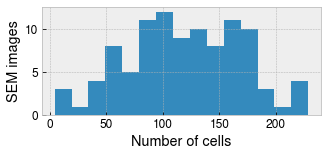

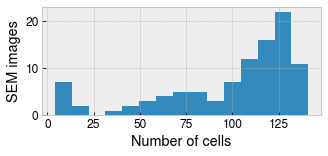

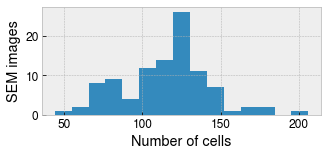

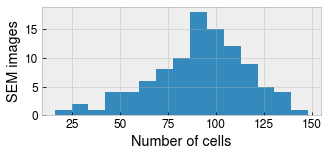

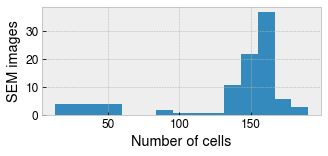

In [27]:
for antibiotics_name in cell_counts.keys():
    plt.figure(figsize=(5, 2))
    plt.style.use('bmh')
    plt.rcParams["font.family"] = "Nimbus Sans"
    plt.rcParams.update({'font.size': 12})
    plt.hist(cell_counts[antibiotics_name], bins=15)
    plt.xlabel('Number of cells')
    plt.ylabel('SEM images')
    #plt.savefig(f'{antibiotics_name}_cell_counts.png', dpi=300, bbox_inches='tight')
    plt.show()